In [1]:
# import required libraries for dataframe and visualization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# import required libraries for clustering

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [2]:
import pandas as pd

retail = pd.read_csv("OnlineRetail_invoice.csv")
retail.head()

,InvoiceNo,InvoiceDate,TTL_price,CustomerID
0,536365,01-12-2010 08:26,27.37,17850.0
1,536366,01-12-2010 08:28,3.70,17850.0
2,536367,01-12-2010 08:34,58.24,13047.0
3,536368,01-12-2010 08:34,19.10,13047.0
4,536369,01-12-2010 08:35,5.95,13047.0


In [3]:
retail.shape

(25900, 4)

In [4]:
retail.describe()

,TTL_price,CustomerID
count,25900.000000,22190.000000
mean,96.478918,15238.498738
std,494.677787,1733.149624
min,-11062.060000,12346.000000
25%,7.410000,13755.000000
50%,31.130000,15136.000000
75%,75.665000,16746.000000
max,38970.000000,18287.000000


# Data Cleaning：移除資料中缺失值

In [5]:
# 检查DataFrame中的缺失值
missing_values = retail.isna().sum()
print(missing_values)

InvoiceNo         0
InvoiceDate       0
TTL_price         0
CustomerID     3710
dtype: int64


In [6]:
# 删除包含缺失值的列
retail.dropna(inplace=True)

# 删除包含缺失值的行
#df.dropna(axis=1, inplace=True)

In [7]:
missing_values = retail.isna().sum()
print(missing_values)

InvoiceNo      0
InvoiceDate    0
TTL_price      0
CustomerID     0
dtype: int64


In [9]:
retail.shape 

(22190, 4)

In [10]:
column_types = retail.dtypes
print(column_types)

InvoiceNo       object
InvoiceDate     object
TTL_price      float64
CustomerID     float64
dtype: object


In [11]:
# 將 customer_id converted to object
retail['CustomerID'] = retail['CustomerID'].astype(object)


column_types = retail.dtypes
print(column_types)

InvoiceNo       object
InvoiceDate     object
TTL_price      float64
CustomerID      object
dtype: object


# Data Preparation

In [34]:
import pandas as pd


# New Attribute : Monetary
rfm_m = retail.groupby('CustomerID')['TTL_price'].sum().reset_index()
rfm_m = rfm_m.rename(columns={'TTL_price':'Monetary'})
rfm_m.head()


,CustomerID,Monetary
0,12346.0,2.08
1,12347.0,481.21
2,12348.0,178.71
3,12349.0,605.10
4,12350.0,65.30


In [35]:
# New Attribute : Frequency

rfm_f = retail.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,7
2,12348.0,4
3,12349.0,1
4,12350.0,1


In [36]:
# Merging the two dfs

rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
rfm.head()

,CustomerID,Monetary,Frequency
0,12346.0,2.08,2
1,12347.0,481.21,7
2,12348.0,178.71,4
3,12349.0,605.10,1
4,12350.0,65.30,1


In [37]:
# New Attribute : Recency

# Convert to datetime to proper datatype
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'],format='%d-%m-%Y %H:%M')

# Compute the maximum date to know the last transaction date
max_date = max(retail['InvoiceDate'])
max_date

# Compute the difference between max date and transaction date
retail['Diff'] = max_date - retail['InvoiceDate']
retail.head()

,InvoiceNo,InvoiceDate,TTL_price,CustomerID,Diff
0,536365,2010-12-01 08:26:00,27.37,17850.0,373 days 04:24:00
1,536366,2010-12-01 08:28:00,3.70,17850.0,373 days 04:22:00
2,536367,2010-12-01 08:34:00,58.24,13047.0,373 days 04:16:00
3,536368,2010-12-01 08:34:00,19.10,13047.0,373 days 04:16:00
4,536369,2010-12-01 08:35:00,5.95,13047.0,373 days 04:15:00


In [38]:
# Compute last transaction date to get the recency of customers
rfm_p = retail.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()

# Extract number of days only
rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [39]:
# Merge tha dataframes to get the final RFM dataframe
rfm = pd.merge(rfm, rfm_p, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'Monetary', 'Frequency', 'Recency']
rfm.head()

,CustomerID,Monetary,Frequency,Recency
0,12346.0,2.08,2,325
1,12347.0,481.21,7,1
2,12348.0,178.71,4,74
3,12349.0,605.10,1,18
4,12350.0,65.30,1,309


In [40]:
# 使用 Pandas 的 loc 方法查找特定 Customer ID 的记录
customer_data = retail.loc[retail['CustomerID'] == 12347.0]

# 打印查找到的记录
print(customer_data)

      InvoiceNo         InvoiceDate  TTL_price CustomerID              Diff
647      537626 2010-12-07 14:57:00      89.59    12347.0 366 days 21:53:00
2651     542237 2011-01-26 14:30:00      73.17    12347.0 316 days 22:20:00
6112     549222 2011-04-07 10:43:00      62.29    12347.0 246 days 02:07:00
9616     556201 2011-06-09 13:01:00      53.62    12347.0 182 days 23:49:00
12492    562032 2011-08-02 08:48:00      68.24    12347.0 129 days 04:02:00
18114    573511 2011-10-31 12:25:00     120.76    12347.0  39 days 00:25:00
21859    581180 2011-12-07 15:52:00      13.54    12347.0   1 days 20:58:00


Text(0.5, 0, 'Attributes')

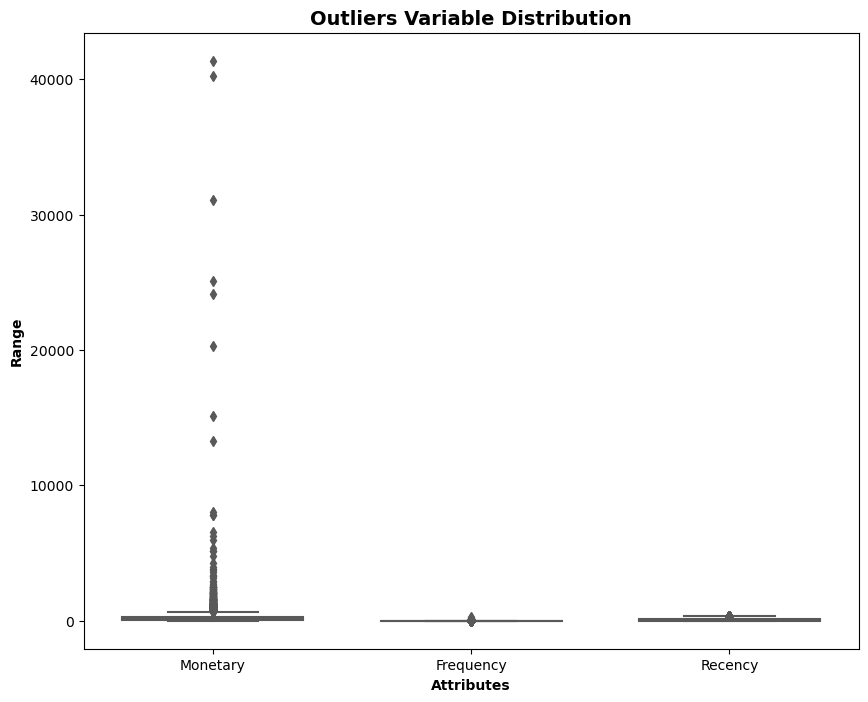

In [41]:
# Outlier Analysis of Amount Frequency and Recency

attributes = ['Monetary','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [44]:
# Removing (statistical) outliers for Monetary
Q1 = rfm.Monetary.quantile(0.05)
Q3 = rfm.Monetary.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Monetary >= Q1 - 1.5*IQR) & (rfm.Monetary <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Recency
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

In [47]:
# Rescaling the attributes

rfm_df = rfm[['Monetary', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4311, 3)

In [48]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Monetary', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Monetary,Frequency,Recency
0,-0.740809,-0.479985,2.306623
1,0.727468,0.526540,-0.902458
2,-0.199533,-0.077375,-0.179424
3,1.107124,-0.681290,-0.734080
4,-0.547074,-0.681290,2.148150


# Building the Model

# 利用Elbow-curve/SSD and Silhouette analysis 來決定合適的分群數量

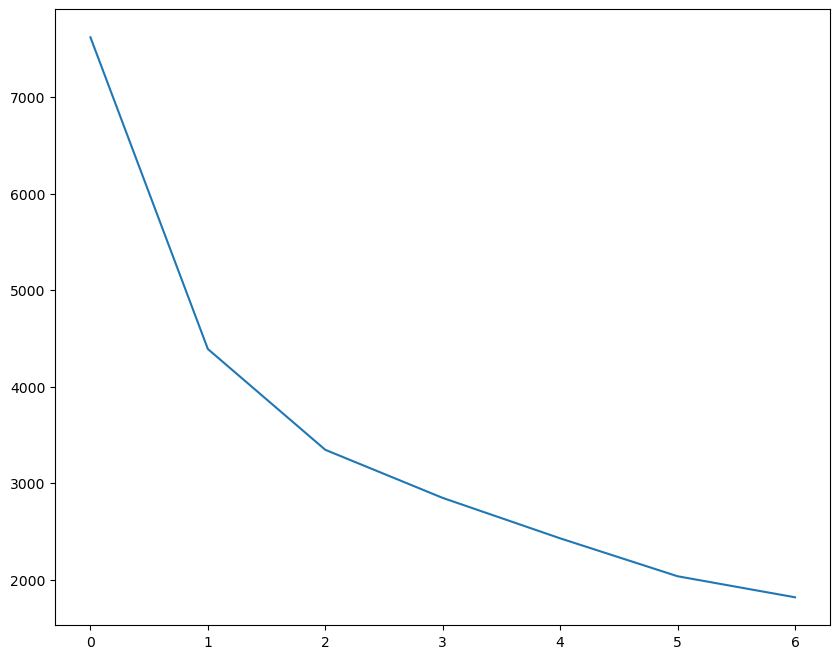

In [49]:
# Elbow-curve/SSD
# 在肘部法中，最佳的分群數通常對應於肘部點，也就是成本（或誤差平方和）開始急劇減小並趨於平穩的位置。

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50,n_init=10)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)

Silhouette分數接近1表示數據點與其所屬簇更相似，與其他簇不相似，這是好的聚類結果。

Silhouette分數接近0表示數據點與多個簇相似，可能處於聚類邊界附近。

Silhouette分數接近-1表示數據點與其所屬簇不相似，與其他簇更相似，這通常是不好的聚類結果。

在圖表中，最高的Silhouette分數對應的K值通常是最佳的分群數。

你可以選擇具有最高Silhouette分數的K值作為最佳的分群數。

In [50]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50,n_init=10)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.5432723059881202
For n_clusters=3, the silhouette score is 0.5041240159188991
For n_clusters=4, the silhouette score is 0.4774956690475617
For n_clusters=5, the silhouette score is 0.4063863318183074
For n_clusters=6, the silhouette score is 0.4155189866625469
For n_clusters=7, the silhouette score is 0.3976244031246385
For n_clusters=8, the silhouette score is 0.3890385595681489


In [51]:
# Final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

/Users/weihsuan/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=50, n_clusters=3)

In [52]:
 kmeans.labels_

array([2, 1, 1, ..., 1, 0, 1], dtype=int32)

In [53]:
# assign the label
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

,CustomerID,Monetary,Frequency,Recency,Cluster_Id
0,12346.0,2.08,2,325,2
1,12347.0,481.21,7,1,1
2,12348.0,178.71,4,74,1
3,12349.0,605.10,1,18,1
4,12350.0,65.30,1,309,2


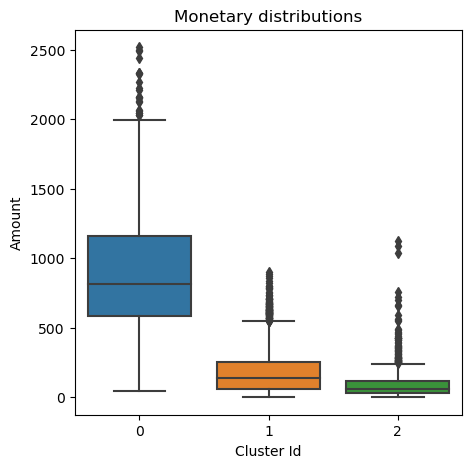

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# 創建一個指定大小的圖形
plt.figure(figsize=(5, 5))

# Box plot to visualize Cluster Id vs Amount
sns.boxplot(x='Cluster_Id', y='Monetary', data=rfm)

# 設定圖形的標題和軸標籤
plt.title('Monetary distributions')
plt.xlabel('Cluster Id')
plt.ylabel('Amount')

# 顯示圖形
plt.show()


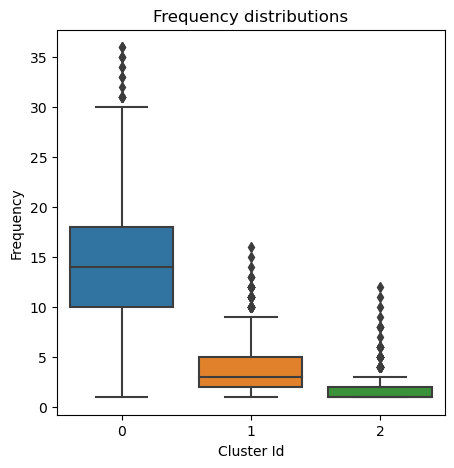

In [55]:
# 創建一個指定大小的圖形
plt.figure(figsize=(5, 5))

# Box plot to visualize Cluster Id vs Frequency
sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm)

# 設定圖形的標題和軸標籤
plt.title('Frequency distributions')
plt.xlabel('Cluster Id')
plt.ylabel('Frequency')

# 顯示圖形
plt.show()

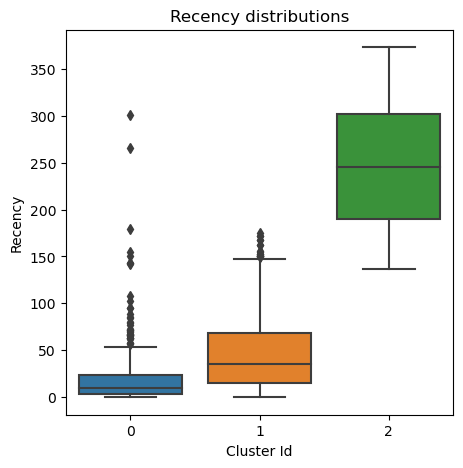

In [56]:
# 創建一個指定大小的圖形
plt.figure(figsize=(5, 5))

# Box plot to visualize Cluster Id vs Frequency
sns.boxplot(x='Cluster_Id', y='Recency', data=rfm)

# 設定圖形的標題和軸標籤
plt.title('Recency distributions')
plt.xlabel('Cluster Id')
plt.ylabel('Recency')

# 顯示圖形
plt.show()

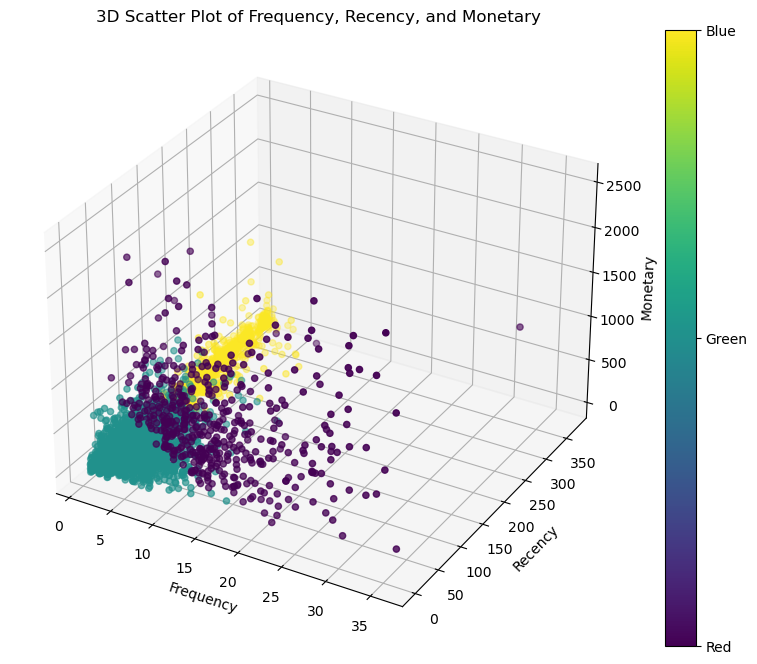

In [58]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 創建一個3D圖形
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 繪制三維散點圖，其中x、y、z分別代表三個特徵
x = rfm['Frequency']
y = rfm['Recency']
z = rfm['Monetary']
c = rfm['Cluster_Id']  # 使用顏色表示簇

scatter = ax.scatter(x, y, z, c=c, cmap='viridis', marker='o')

# 添加軸標籤
ax.set_xlabel('Frequency')
ax.set_ylabel('Recency')
ax.set_zlabel('Monetary')

# 添加標題
ax.set_title('3D Scatter Plot of Frequency, Recency, and Monetary')

# 定義三個顏色
colors = ['red', 'green', 'blue']

# 添加顏色條
cbar = fig.colorbar(scatter)
cbar.set_ticks([0, 1, 2])  # 設置顏色刻度
cbar.set_ticklabels(['Red', 'Green', 'Blue'])  # 設置顏色標籤


# 顯示圖形
plt.show()


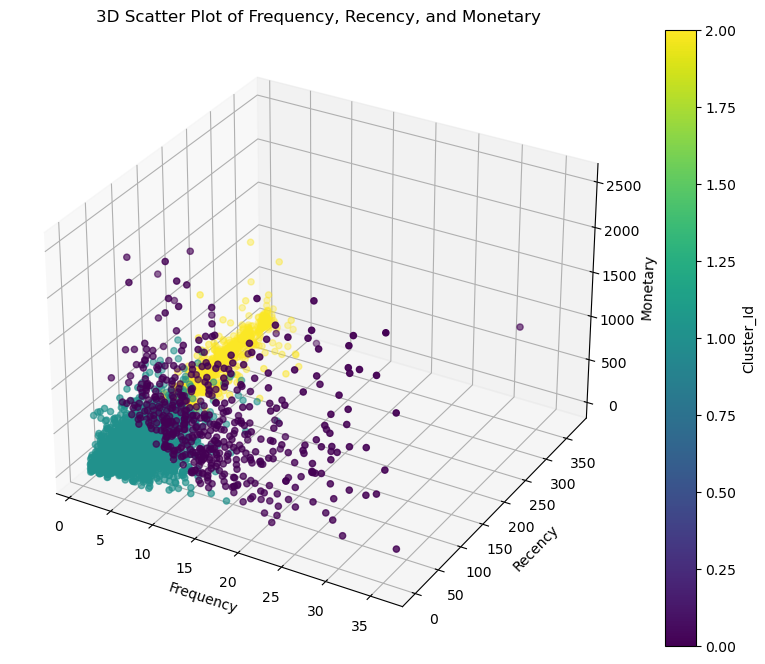

interactive(children=(IntSlider(value=180, description='angle', max=360, step=5), Output()), _dom_classes=('wi…

In [59]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact

# 创建一个3D图形
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 绘制三维散点图，其中x、y、z分别代表三个特征
x = rfm['Frequency']
y = rfm['Recency']
z = rfm['Monetary']
c = rfm['Cluster_Id']  # 使用颜色表示簇

# 绘制散点图
scatter = ax.scatter(x, y, z, c=c, cmap='viridis', marker='o')

# 添加轴标签
ax.set_xlabel('Frequency')
ax.set_ylabel('Recency')
ax.set_zlabel('Monetary')

# 添加标题
ax.set_title('3D Scatter Plot of Frequency, Recency, and Monetary')

# 添加颜色条
cbar = fig.colorbar(scatter)
cbar.set_label('Cluster_Id')

# 定义一个函数来旋转视角
def rotate_plot(angle):
    ax.view_init(elev=20, azim=angle)

# 创建互动控制，可以用来旋转图表
interact(rotate_plot, angle=(0, 360, 5))

# 显示图形
plt.show()
